#### Check GPU

In [197]:
!nvidia-smi

/bin/bash: /home/djbacad/miniconda3/envs/tensorflow-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun May  7 02:02:42 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.50                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060         On | 00000000:01:00.0  On |                  N/A |
| N/A   67C    P0               36W /  N/A|   5810MiB /  6144MiB |      2%      Default |
|                         

In [198]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Ensure reproducibility by setting global seed

In [199]:
tf.keras.backend.clear_session()
import os
import numpy as np
from tensorflow.compat.v1 import ConfigProto
SEED_VALUE = 1
os.environ['TF_DETERMINISTIC_OPS'] = str(SEED_VALUE)
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
os.environ["CUDA_VISIBLE_DEVICES"] = str(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                        inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-05-07 02:02:42.588624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-07 02:02:42.588751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-07 02:02:42.588795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-07 02:02:42.589897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-07 02:02:42.590004: I tensorflow/core/co

#### Import libraries

In [200]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Initialize tunable hyperparameters

In [201]:
EPOCHS = 40
BATCH_SIZE = 8
IMG_SIZE = 224
#Adabelief HPs:
INIT_LEARNING_RATE = 5e-3
TL_EPSILON = 1e-10
TL_WEIGHT_DECAY = 1e-2

#### Load the data and assign the train, val, and test sets

In [202]:
data_loc = '/mnt/e/files_main/projects_ml/guitar-chord-detection/data/Images'

# Train-Val-Test: 70-10-20

# Train
train_set = tf.keras.utils.image_dataset_from_directory(
  directory=data_loc,
  validation_split=0.3,
  subset="training",
  seed=SEED_VALUE,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  shuffle=True
)

# Val
val_set = tf.keras.utils.image_dataset_from_directory(
  directory=data_loc,
  validation_split=0.3,
  subset="validation",
  seed=SEED_VALUE,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  shuffle=True
)

# Test
# Create the test set by breaking down the validation set.
val_batches = tf.data.experimental.cardinality(val_set)
val_set = val_set.skip((2*val_batches) // 3)
test_set = val_set.take((2*val_batches) // 3)

Found 60 files belonging to 3 classes.
Using 42 files for training.
Found 60 files belonging to 3 classes.
Using 18 files for validation.


In [203]:
class_names = np.array(train_set.class_names)
print(class_names)

['C' 'D' 'G']


In [204]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 224, 224, 3)
(8,)


2023-05-07 02:02:44.444627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [42]
	 [[{{node Placeholder/_4}}]]
2023-05-07 02:02:44.445135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [42]
	 [[{{node Placeholder/_0}}]]


#### Use buffered prefetching for performance

In [205]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.prefetch(buffer_size=AUTOTUNE)
val_set = val_set.prefetch(buffer_size=AUTOTUNE)
test_aset = test_set.prefetch(buffer_size=AUTOTUNE)

#### Define the on-the-fly data augmentation steps

In [206]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Create the base model

In [207]:
base_model = tf.keras.applications.MobileNetV3Small(weights = 'imagenet',
                          include_top = False, 
                          pooling = 'avg',
                          input_shape = (IMG_SIZE, IMG_SIZE, 3)) 


# Freeze
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

#### Attach the new top layers / classification head

In [208]:
# global_average_layer = GlobalAveragePooling2D()
# prediction_layer = Dense(3)

# inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x) #Specific preprocess_input from EfficientNetV2B0 keras application
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=False)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x,training=False)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x,training=False)
# x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x,training=False)
outputs = Dense(3, activation='softmax')(x)
transfer_model = Model(inputs, outputs)

#### Compile the model

In [209]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

# efficientnetb0_transfer_model.compile(optimizer = optim, 
#                           loss = 'categorical_crossentropy', 
#                           metrics=['accuracy'])

In [210]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, None)    0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3843

In [211]:
history = model.fit(train_set,
                    epochs=100,
                    validation_data=val_set)

Epoch 1/100


2023-05-07 02:02:52.038054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [42]
	 [[{{node Placeholder/_0}}]]
2023-05-07 02:02:52.038536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [42]
	 [[{{node Placeholder/_4}}]]


5/6 [========================>.....] - ETA: 0s - loss: 0.0070 - acc: 1.0000

2023-05-07 02:03:01.064764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [18]
	 [[{{node Placeholder/_4}}]]
2023-05-07 02:03:01.065216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [18]
	 [[{{node Placeholder/_4}}]]


6/6 [==============================] - 11s 443ms/step - loss: 0.0073 - acc: 1.0000 - val_loss: 0.0950 - val_acc: 1.0000
Epoch 2/100
6/6 [==============================] - 0s 63ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0814 - val_acc: 1.0000
Epoch 3/100
6/6 [==============================] - 0s 64ms/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 4/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 1.0000
Epoch 5/100
6/6 [==============================] - 1s 73ms/step - loss: 0.0092 - acc: 1.0000 - val_loss: 1.1616 - val_acc: 0.5000
Epoch 6/100
6/6 [==============================] - 0s 68ms/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.7597 - val_acc: 0.5000
Epoch 7/100
6/6 [==============================] - 0s 56ms/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.8721 - val_acc: 0.5000
Epoch 8/100
6/6 [==============================] - 0s 64ms/step - loss: 0.0054 - acc: 1.0000 - val_l

KeyboardInterrupt: 

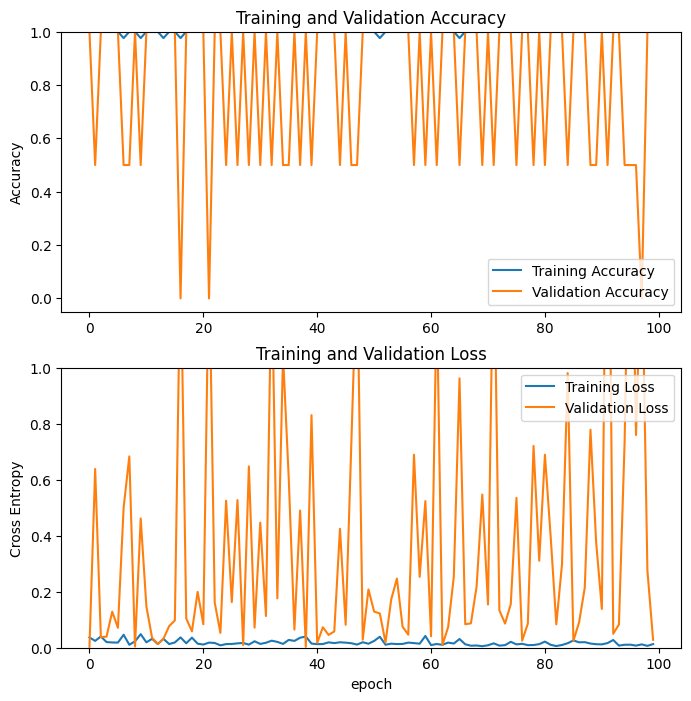

In [196]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [85]:
# Latest EfficientNet architecture
# Feature vectors of images with input size 240x240, trained on imagenet-21k
efficientnet_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2"
feature_extractor = efficientnet_v2

In [86]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor,
    input_shape=(IMG_SIZE_V1, IMG_SIZE_V1, 3),
    trainable=False) #Freeze so that training happens only on the top layer.

In [92]:
feature_extractor_layer

In [91]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

ValueError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * <tf.Tensor 'inputs:0' shape=(32, 240, 240, 1) dtype=float32>
    * False
    * False
  Keyword arguments: {}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1')
    * False
    * False
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
    * False
    * False
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
    * True
    * False
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1')
    * True
    * False
  Keyword arguments: {}

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs=tf.Tensor(shape=(32, 240, 240, 1), dtype=float32)
  • training=None

#### Attach the top layer / classification head

In [89]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])


In [90]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.